# Financial Independence - Monte Carlo Simulation
## Theoretical model

The theory behind the following equations can be found in [this notebook](https://github.com/OlegZero13/Data-Science-Algorithm-Gallery/blob/master/Personal_Financial_Simulator_with_ODE.ipynb) and [this article](https://zerowithdot.com/financial-independence-ode-python/).
It is based on numerically solving a system of coupled _ordinary differential equations_:

$$
\left\{\begin{matrix}
\frac{d}{dt} x_1(t) &= \Delta (1 - \beta) - x_1\ln(1 + \xi) \\
\frac{d}{dt} x_2(t) &= \beta \Delta + x_2\ln(1 + R) - x_2\ln(1 + \xi)
\end{matrix}\right.
$$

where
* $x_1$ and $x_2$ denote the "living wallet" (home budget) and the "investment bucket", respectively.
* $\xi$ is an `inflation rate`.
* $\Delta = a(t) - s(t) - T(a)$ is the amount that is left each year.
* $a(t) = \alpha_0 + \alpha_1 t$ is the `income`, where $\alpha_1$ represents a pay rise.
* $s(t) = \sigma_0 + \sigma_1 t$ is the yearly spending.
* $T(a)$ represents the tax paid (it can be progressive or linear).:
* $R$ is the (average) interest rate upon investment
* $\beta$ is the fraction of the baseline budget $x_1$ we transfer to the investment bucket $x_2$.

The timeline is divided into three stages:
* the "youth", where you basically make no money,
* the "adulthood", where you earn, spend, invest and pay taxes, and
* the "old age", where your salary is replaced with pension, but the spending stays purpously the same.

It is also assumed, that once you transition from the _adulthood_ to the _old age_, $x_1$ and $x_2$ blend into $x_1$, meaning you no longer invest, but rather eat the fruits of your work. Note that even when a _hybrid_ lifestyle is possible, as you continue to invest lower amounts, we do not consider it here for simplicity.

The goal is to see how far you can make it.

### Basic model

In [1]:
import numpy as np
import pandas as pd

from scipy.integrate import odeint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [242]:
class Life:
    def __init__(self):
        self.starting_age = 25
        self.retirement_age = 67
        self.income = 1
        self.pay_rise = 0.0
        self.tax_type = 'None'
        self.pension = 0
        self.costs = 0.7
        self.life_inflation = 0.0
        self.investment_fraction = 0.1
        self.interest_rate_proc = 10
        self.inflation_proc = 2.5

    def earn(self, t):
        if t < self.starting_age:
            return 0
        elif self.starting_age <= t < self.retirement_age:
            return 12 * (self.income + self.pay_rise * (t - self.starting_age))
        else:
            return 12 * self.pension

    def spend(self, t):
        if (t < self.starting_age):
            return 0
        return 12 * (self.costs + self.life_inflation * (t - self.starting_age))

    def pay_taxes(self, t):
        if (t < self.starting_age) or (t > self.retirement_age):
            return 0
        earning = self.earn(t)
        if self.tax_type == 'UoP':
            if earning < 85528.0:
                return 0.17 * earning
            else:
                return 13983.74 - 0.32 * (earning - 85528)
        elif self.tax_type == 'B2B':
            return 0.19 * earning
        else:
            return 0


def live(x, t, you):
    balance = you.earn(t) - you.spend(t) - you.pay_taxes(t)
    x0 = 0
    x1 = np.log(1 + 0.01*you.interest_rate_proc) * x[1]

    if balance >= 0:
        x0 = balance * (1 - you.investment_fraction)
        x1 += you.investment_fraction * balance
    else:
        x0 += -balance
        x1 += balance

         
    x0 = x0 - np.log(1 + 0.01*you.inflation_proc) * x[0]
    x1 = x1 - np.log(1 + 0.01*you.inflation_proc) * x[1]
    return [x0, x1]

### Simulation

In [243]:
def simulate(you):
    t0 = np.linspace(0, you.starting_age - 1, num=you.starting_age)
    t1 = np.linspace(you.starting_age, you.retirement_age - 1, num=(you.retirement_age - you.starting_age))
    t2 = np.linspace(you.retirement_age, 200, num=(100 - you.retirement_age + 1))

    x_t0 = np.zeros((t0.shape[0], 2))
    x_t1 = odeint(live, [0, 0], t1, args=(you,))
   # x_t2 = odeint(live, [x_t1[-1].sum(), 0], t2, args=(you,))
    x_t2 = odeint(live, x_t1[-1], t2, args=(you,))

    df0 = pd.DataFrame({'time': t0, 'x_1': x_t0[:, 0], 'x_2': x_t0[:, 1], 'total': x_t0.sum(axis=1)})
    df1 = pd.DataFrame({'time': t1, 'x_1': x_t1[:, 0], 'x_2': x_t1[:, 1], 'total': x_t1.sum(axis=1)})
    df2 = pd.DataFrame({'time': t2, 'x_1': x_t2[:, 0], 'x_2': x_t2[:, 1], 'total': x_t2.sum(axis=1)})
    return pd.concat([df0, df1, df2]).set_index('time')

In [246]:
you = Life()

you.starting_age        = 18   # y.o.
you.retirement_age      = 67   # y.o.
you.income              = 5000 # monthly
you.pay_rise            = 0  # yearly
you.tax_type            = "B2B"
you.pension             = 0  # monthly
you.costs               = 2000  # monthly
you.life_inflation      = 0  # yearly
you.investment_fraction = 0.75  # beta
you.interest_rate_proc  = 5.0 # R
you.inflation_proc      = 2.8  # xi

df = simulate(you)

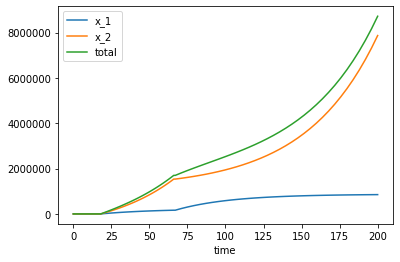

In [247]:
df.plot()#ylim=(-1000, None))

## Adding random factor

In [ ]:
class RealLife(Life):
    